<a href="https://colab.research.google.com/github/LM1997610/DMT/blob/main/HW_1_DMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DMT 2023 - Homework 1

## Group composition:


<br>

------------YOUR TEXT STARTS HERE------------

<br>

*   Mazzucco, Luca, 1997610
*   Zilviano, Paolo, 1916518





<div style="page-break-after: always; visibility: hidden"> 
\pagebreak
</div>

## Homework 1
The homework consists of two parts:

  1. Search-Engine Evaluation

  2. Near-Duplicate-Detection


# Part 1
In this part of the homework, you have to index collections of documents to build search-engines using the PyTerrier library.

Import **ALL** the Python packages that you need for Part 1.

In [1]:
#REMOVE_OUTPUT#
%%capture
!pip install --upgrade --no-cache-dir gdown
!pip install python-terrier
#YOUR CODE STARTS HERE#

import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import pyterrier as pt

#YOUR CODE ENDS HERE#
#THIS IS LINE 15#

## Part 1.1
You have to build a search engine for the book *Le Morte D’Arthur* by Thomas Malory and **improve the search-engines performance** (the higher the better). The book is divided into two volumes. Each chapter is a document with two fields: title of the chapter and corpus of the chapter. You only want to index the corpus of each chapter.

### 1.1.1
Download the data from the Drive link (code already provided).

In [2]:
#REMOVE_OUTPUT#
!gdown 1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
!gdown 1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut

Downloading...
From: https://drive.google.com/uc?id=1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html
100% 964k/964k [00:00<00:00, 502MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html
100% 1.10M/1.10M [00:00<00:00, 510MB/s]


### 1.1.2
Parse the HTML. **Part** of code already provided: follow the comments to complete the code.


In [3]:
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html') as fp:
    vol1 = bs(fp, 'html.parser')
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html') as fp:
    vol2 = bs(fp, 'html.parser')

def clean_text(txt):
    words_to_put_space_before = [".",",",";",":","’","'"]
    words_to_lowercase = ["First","How","Some","Yet","Of","A","The","What","Fifth"]
    
    app = txt.replace("\n"," ")
    for word in words_to_put_space_before:
        app = app.replace(word," "+word)
    for word in words_to_lowercase:
        app = app.replace(word+" ",word.lower()+" ")
    return app.strip()

def parse_html(soup):
    titles = []
    texts = []
    for chapter in soup.find_all("h3"):
        chapter_title = chapter.text
        if "CHAPTER" in chapter_title:
            chapter_title = clean_text("".join(chapter_title.split(".")[1:]))
            titles.append(chapter_title)
            
            chapter_text = [p.text for p in chapter.findNextSiblings("p")]
            chapter_text = clean_text(" ".join(chapter_text))
            texts.append(chapter_text)
    return titles, texts

In [4]:
#YOUR CODE STARTS HERE#
#Extract all the chapters' titles and texts from the two volumes

titles_1, texts_1 = parse_html(vol1)
titles_2, texts_2 = parse_html(vol2)


num_doc = [str(i).zfill(1) for i in range(1,len(titles_1 + titles_2)+1)]


df = pd.DataFrame(zip(num_doc, titles_1+titles_2, texts_1+texts_2), 
                  columns=["docno", 'Titles', 'Texts'])

print("\ndf.shape:", df.shape)




#YOUR CODE ENDS HERE#
#THIS IS LINE 20#


df.shape: (503, 3)


Print the first 8 rows of the DataFrame.

[comment]: <> (#SHOW_CELL#)

In [5]:
from tabulate import tabulate

In [6]:
#YOUR CODE STARTS HERE#

a_table = df[["Titles", "Texts"]].apply(lambda x: x.str[:25]+"...").head(8)

print()
print(tabulate(a_table, headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
print()

#YOUR CODE ENDS HERE#
#THIS IS LINE 10#


               Titles                        Texts
--  ----------------------------  ----------------------------
0   first , how Uther Pendrag...  It befell in the days of ...
1   how Uther Pendragon made ...  Then Ulfius was glad , an...
2   of the birth of King Arth...  Then Queen Igraine waxed ...
3   of the death of King Uthe...  Then within two years Kin...
4   how Arthur was chosen kin...  Then stood the realm in g...
5   how King Arthur pulled ou...  Now assay , said Sir Ecto...
6   how King Arthur was crown...  And at the feast of Pente...
7   how King Arthur held in W...  Then the king removed int...



### 1.1.3
Extract character's names from the **titles** only. **Part** of code already provided: follow the comments to complete the code.

In [7]:
all_characters = set()
def extract_character_names_from_string(string_to_parse):
    special_tokens = ["of","the","le","a","de"]

    remember = ""
    last_is_special_token = False

    tokens = string_to_parse.split(" ")
    characters_found = set()
    for i,word in enumerate(tokens):
        if word[0].isupper() or (remember!="" and word in special_tokens):
            word = word.replace("'s","").replace("’s","")
            last_is_special_token = False
            if remember!="":
                if word in special_tokens:
                    last_is_special_token = True
                remember = remember+" "+word
            else: remember = word
        else:
            if remember!="":
                if last_is_special_token:
                    for tok in special_tokens:
                        remember = remember.replace(" "+tok,"")
                characters_found.add(remember)
            remember = ""
            last_is_special_token = False
    return characters_found

#all_characters = set([x for x in characters_found if x[-2:]!="'s"])

In [8]:
#YOUR CODE STARTS HERE#
#Extract all characters' names

all_characters = df["Titles"].apply(extract_character_names_from_string)
all_characters = set.union(*map(set, all_characters)) 


print(" All_characters: ", all_characters, sep=" ")





#YOUR CODE ENDS HERE#
#THIS IS LINE 15#

 All_characters:  {'Sir Meliagrance', 'Joyous Isle', 'Isle', 'Sir Alisander', 'Knights of the Round Table', 'Sir Palomides', 'Beale Isoud', 'Castle Lonazep', 'Excalibur', 'Alisander', 'Sir Galihodin', 'Fair Maid of Astolat', 'Launcelot', 'Alisander le Orphelin', 'Lionel', 'Sir Urre', 'Sir Mador', 'Damosel of the Lake', 'Sir Lionel', 'David', 'Our Lord', 'Sir Launcelot', 'Ulfius', 'La Beale Isoud', 'Queen of Orkney', 'Sir Suppinabiles', 'Queen Guenever', 'Lanceor', 'Sir Brian', 'Avoutres', 'God', 'Helin le Blank', 'Uther Pendragon', 'York', 'King Uriens', 'Leodegrance', 'Romans', 'Sir Ector', 'Carlion', 'Gard', 'Sir Dagonet', 'Humber', 'Winchester', 'Sir Accolon', 'Sir Galahad', 'Beale Pilgrim', 'Sir Uriens', 'Melias', 'Abbot', 'Accolon', 'Balan', 'Sir Dinadan', 'Lucius', 'Joyous Gard', 'La Cote Male Taile', 'Sir Lamorak', 'Morgan le Fay', 'Sir Belliance', 'Sir Safere', 'Sir Gawaine', 'Sir Amant', 'Sir Segwarides', 'King Arthur', 'Queen Igraine', 'Gawaine', 'Sir Sadok', 'Surluse', 'Lady

Print the names of all the kings (i.e. characters with `King` in their name).

[comment]: <> (#SHOW_CELL#)

In [9]:
#YOUR CODE STARTS HERE#

kings = { person for person in  all_characters  if person.lower().find("king") > -1  } 

print(" Kings:", kings, sep=" ")



#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

 Kings: {'King Arthur', 'King Howel of Brittany', 'King Ban', 'King Solomon', 'King Anguish of Ireland', 'King Brandegore', 'King Lot of Orkney', 'Maimed King', 'King Mark', 'King Bagdemagus', 'King Evelake', 'King Mark of Cornwall', 'King Pelles', 'King Lot', 'King Mordrains', 'King Uriens', 'King of the Land of Cameliard', 'King Pellinore', 'King', 'King Bors', 'King Rience', 'King Pelleas', 'King Leodegrance', 'King Pellam', 'King of England'}


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.4
Some names refer to the same characters (e.g. `'Arthur' = 'King Arthur'`). A function is provided to extract the disambiguation dictionary: each key represents a name and the value represents the true character name (e.g. `{'Arthur': 'King-Arthur', 'King': 'King-Arthur', 'Bedivere':'Sir Bedivere'}`). Disambiguation sets, i.e. a list with sets representing the multiple names of a single character, are also provided.

> There may be some mistakes, but it does not matter (e.g. `'Cornwall' = 'King of Cornwall'`)

In [10]:
disambiguate_to = {}
for x in all_characters:
    for y in all_characters:
        if x in y and x!=y:
            if x in disambiguate_to:
                previous_y = disambiguate_to[x]
                if len(y)>len(previous_y): disambiguate_to[x] = y
            else:
                disambiguate_to[x] = y
disambiguate_to.update({"King": "King Arthur",
                        "King of England": "King Arthur",
                        "Queen": "Queen Guenever",
                        "Sir Lancelot": "Sir Launcelot"})

disambiguate_sets = []
for x,y in disambiguate_to.items():
    inserted = False
    for z in disambiguate_sets:
        if x in z or y in z:
            z.add(x); z.add(y)
            inserted = True
    if not inserted:
        disambiguate_sets.append(set([x,y]))

while True:
    to_remove,to_add = [],[]
    for i1,s1 in enumerate(disambiguate_sets[:-1]):
        for s2 in disambiguate_sets[i1+1:]:
            if len(s1.intersection(s2))>0:
                to_remove.append(s1)
                to_remove.append(s2)
                to_add.append(s1.union(s2))
    if len(to_add)>0:
        for rm in to_remove:
            disambiguate_sets.remove(rm)
        for ad in to_add:
            disambiguate_sets.append(ad)
    else: break

### 1.1.5
Prepare the topics for the queries.

> Each character name (including alternative names) represents a topic.

In [11]:
#YOUR CODE STARTS HERE#


top = [(j,i[0]) for i in enumerate(disambiguate_sets,1) for j in list(i[1])]
mistakes= ["King", "England", "Queen"]
top = [x for x in top if x[0] not in mistakes]

topics = pd.DataFrame({'query': [x[0] for x in top], "qid": [str(i[1]) for i in top]})



if not pt.started(): pt.init()

#YOUR CODE ENDS HERE#
#THIS IS LINE 30#

terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



Print the first 5 rows.

[comment]: <> (#SHOW_CELL#)

In [12]:
#YOUR CODE STARTS HERE#


print()
print(tabulate(topics.head(5), headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
print()


#YOUR CODE ENDS HERE#
#THIS IS LINE 10#


        query        qid
--  --------------  -----
0        Isle         1
1    Joyous Isle      1
2    Beale Isoud      2
3   La Beale Isoud    2
4       Isoud         2



### 1.1.6
Prepare the relevance scores for the queries.

> A document is considered relevant (1) if its **corpus** contains the character's name or one of its alternative names, otherwise is not relevant (0).

In [13]:
#YOUR CODE STARTS HERE#

topid, top_r  = list(), list()

for i in range(len(top)):
    for j in range(len(texts_1+texts_2)):
          top_r.append(str(top[i][0]))
          topid.append(str(top[i][1]))
rs = []
for i in top:
  for j in texts_1+texts_2:
    if i[0] in j:
      rs.append(1)
    else:
      rs.append(0)

df_scores =  pd.DataFrame({'qid': topid, 'label':rs, 'docno':num_doc*len(top)})

#YOUR CODE ENDS HERE#
#THIS IS LINE 30#

Print the first and last row, and the shape of the DataFrame.

[comment]: <> (#SHOW_CELL#)

In [14]:
#YOUR CODE STARTS HERE#

print("\ndf_scores.shape: {}\n".format(df_scores.shape))
print()
print(tabulate(df_scores.iloc[[0, -1]], headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
print()


#YOUR CODE ENDS HERE#
#THIS IS LINE 10#


df_scores.shape: (48288, 3)


        qid    label    docno
-----  -----  -------  -------
  0      1       0        1
48287   44       0       503



### 1.1.7
Choose several preprocessing configurations (at least 2, no more than 4).

For each of them, construct an index on the `title` field.

For the last of them, report the number of indexed documents and terms.

In [15]:
import warnings 
warnings.filterwarnings('ignore')

In [16]:
#YOUR CODE STARTS HERE#
prepr_conf = ["", "Stopwords", "EnglishSnowballStemmer", "Stopwords, EnglishSnowballStemmer"]

def create_index(preprocessing_configuration, field, numero):
  pd_indexer = pt.DFIndexer("./Inverted_Index_"+str(numero), overwrite=True)
  pd_indexer.setProperty("termpipelines", preprocessing_configuration)
  indexref = pd_indexer.index(df[field], df["docno"]); return indexref

indexes, c = list(), 0

for configuration in prepr_conf:
  indexref = create_index(configuration, "Texts", c)
  indexes.append(indexref)
  c+=1

index_factory = pt.IndexFactory.of(indexes[-1])
print("\nNumber of indexed documents: {} \nNumber of indexed terms: {}".format(index_factory.getCollectionStatistics().getNumberOfDocuments(),
                                                                      index_factory.getCollectionStatistics().getNumberOfUniqueTerms()))
#YOUR CODE ENDS HERE#
#THIS IS LINE 20#


Number of indexed documents: 503 
Number of indexed terms: 4542


### 1.1.8
Choose several weighting models (at least 2, no more than 5).

For each of them, for each of the indices created in last step, build a retrieval model.

In [17]:
#YOUR CODE STARTS HERE#

def create_retrieval_model(indexref, scoring_function):
  return pt.BatchRetrieve(indexref, wmodel = scoring_function)

weight_models = ["CoordinateMatch", "TF_IDF", "BM25", "DPH", "Hiemstra_LM"]
models = {}

for i in range(len(indexes)):
  idx_ref = indexes[i]
  w = []

  for wmodel in weight_models:
    retrieval_model = create_retrieval_model(idx_ref, wmodel)
    w.append(retrieval_model)
  models[i] = w


#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

### 1.1.9
Choose several evaluation metrics (at least 3, no more than 6) and put them in a list.

Add the following metrics to the list: Recall at 5, Normalized Discounted Cumulative Gain at 20, Mean Average Precision.

Obviously, the metrics you choose cannot be **completely identical** to these 3 we specified.

In [18]:
#YOUR CODE STARTS HERE#


ours = [ "P_3", "P_5", "recip_rank", "mrt", "recall_10", "ndcg_cut_10"]

requested = ['recall_5', 'ndcg_cut_20', 'map']

metrics = sorted(ours + requested)





#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

### 1.1.10
For each index built in step 1.1.7, run an experiment to obtain the values associated to each evaluation metrics specified in 1.1.8 for each of the weighting models chosen in 1.1.9.

In [19]:
#YOUR CODE STARTS HERE#

experiments = []

for i in models:

  res_exp = pt.Experiment(
      models[i],
      topics = topics, qrels = df_scores,
      eval_metrics = metrics,
      names = weight_models ,
      highlight = "bold", verbose=True)

  experiments.append(res_exp)




#YOUR CODE ENDS HERE#
#THIS IS LINE 30#

pt.Experiment:   0%|          | 0/5 [00:00<?, ?system/s]

pt.Experiment:   0%|          | 0/5 [00:00<?, ?system/s]

pt.Experiment:   0%|          | 0/5 [00:00<?, ?system/s]

pt.Experiment:   0%|          | 0/5 [00:00<?, ?system/s]

### 1.1.11
For the last index constructed (i.e. corresponding to the last preprocessing chosen), print out the PyTerrier table with the weighting models chosen by you on the rows and the evaluation metrics chosen by you + those specified by us on the columns. 

Highlight the best results in the result table.

In [20]:
#YOUR CODE STARTS HERE#

last = -1

print("\nlast index constructed → preprocessing : ({})\n".format(prepr_conf[last]))
print(tabulate(experiments[last].data, headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
print()

#YOUR CODE ENDS HERE#
#THIS IS LINE 10#


last index constructed → preprocessing : (Stopwords, EnglishSnowballStemmer)

         name          P_3       P_5       map      ndcg_cut_10    ndcg_cut_20    recall_10    recall_5    recip_rank     mrt
--  ---------------  --------  --------  --------  -------------  -------------  -----------  ----------  ------------  -------
0   CoordinateMatch  0.416667  0.413636  0.48074     0.449549       0.465518      0.308872     0.177045     0.445113    7.02443
1       TF_IDF       0.757576  0.722727  0.761265    0.777932       0.790845      0.491628     0.351214     0.797913    6.39384
2        BM25        0.666667  0.654545  0.724824    0.706139       0.740637      0.459263     0.319203     0.709364    6.54646
3         DPH        0.742424  0.736364  0.749321    0.777103       0.796797      0.484349     0.33262      0.800796    8.61856
4     Hiemstra_LM    0.757576  0.731818   0.7372     0.778152       0.789929      0.492338     0.330169     0.80465     6.55072



### 1.1.12
Select the Top-4 configurations (preprocessing, weighting model) according to the Mean Average Precision (MAP), taking into account the results obtained in section 1.1.10.

For these 4 configurations, provide the following plot (re-run the evaluations just for this configurations, to get the required evaluation metrics):

* Recall@k plot
    * the x axis represents the considered values for k: you must consider k 𝜖 {1, 3, 5, 10, 20, 50}
    * the y axis represents the average Recall@k over all provided queries
    * each curve represents one of the 4 search engine configurations

pt.Experiment:   0%|          | 0/4 [00:00<?, ?system/s]


     name    recall_1    recall_3    recall_5    recall_10    recall_20    recall_50
--  ------  ----------  ----------  ----------  -----------  -----------  -----------
0   TF_IDF  0.0717277    0.238988    0.351214    0.491628     0.670364     0.838288
1   TF_IDF  0.0717277    0.238988    0.351214    0.491628     0.672756     0.839182
2   TF_IDF  0.0717277    0.24071     0.326813    0.490214     0.682858     0.850473
3   TF_IDF  0.0717277    0.24071     0.326813    0.512941     0.682858     0.850776



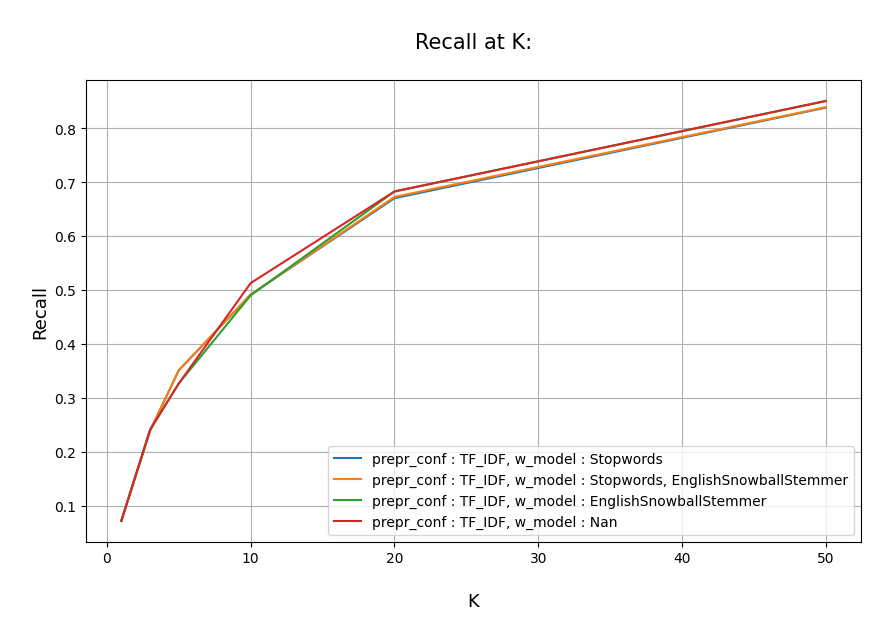

In [21]:
#YOUR CODE STARTS HERE#

k = [1, 3, 5, 10, 20, 50]
metrics_2 = ['recall_'+str(x) for x in k]

frame = pd.concat([x.data for x in experiments])
frame["prepr_conf"] = prepr_conf*5
frame = frame.sort_values(by=['map'], ascending=False).head(4)
indici = [prepr_conf.index(i) for i in frame["prepr_conf"]]


lista = [models[x][j] for x,j in zip(indici,frame.index)]

res_exp = pt.Experiment( lista, topics = topics, qrels = df_scores, verbose=True,
                                  eval_metrics = metrics_2, names = frame.name, highlight = "bold")
print("")                       
print(tabulate(res_exp.data, headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
print("")

plt.figure(figsize=(10,6))

for i in range(4):
  row = res_exp.data.iloc[i][1:]
  plt.plot(k, row)

frame.loc[frame["prepr_conf"] == "", "prepr_conf"] = "Nan"
lgn = ["prepr_conf : "+ i + ", w_model : "+ j for i,j in zip(frame.name, frame.prepr_conf)]

plt.legend(lgn)
plt.title("\nRecall at K:\n", fontsize= 15)
plt.xlabel("\nK", fontsize=13)
plt.ylabel("\nRecall", fontsize=13)
plt.grid()
plt.show()



#YOUR CODE ENDS HERE#
#THIS IS LINE 50#

### 1.1.13
According only to the Recall@k plot, which is the best search engine configuration? Explain your answer in **at most 3 sentences**.

<br>

------------YOUR TEXT STARTS HERE------------

<br>

According only to the Recall_k plot, all search engine configurations are very similar to each other.\
Best search engine is the one implemented with stemming and stopwords removal and TF-IDF as weighting model, since this has a higher Recall.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.14
For the configuration you selected in Part 1.1.13, provide an **example of the functioning** of your search enginge.

The query should be `King Mark of Cornwall`.

In [22]:
#YOUR CODE STARTS HERE#


query = "King Mark of Cornwall"

q = models[3][1].search(query,)

print("q.shape :", q.shape, "\n")

print(tabulate(pd.concat([q.iloc[:3], q.iloc[-3:]]) , headers='keys', 
               tablefmt = "heavy_outline", numalign='center', stralign="center"))


#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

q.shape : (428, 6) 

      qid    docid    docno    rank    score            query
---  -----  -------  -------  ------  --------  ---------------------
 0     1      157      158      0     7.52123   King Mark of Cornwall
 1     1      158      159      1     7.15052   King Mark of Cornwall
 2     1      245      246      2     6.90861   King Mark of Cornwall
425    1      448      449     425    0.494038  King Mark of Cornwall
426    1      82       83      426    0.450573  King Mark of Cornwall
427    1      313      314     427    0.439929  King Mark of Cornwall


## Part 1.2

You will be given a scenario and some requirements to fulfill. By respecting the requirements, you will have to choose the proper **configuration**, represented in terms of:
1. A suitable preprocessing (if any)
2. A suitable weighting model (if any)
3. A suitable evaluation metric (if any)

You must then provide an explanation of your choice in **at most 3 sentences**.

N.B. There is not necessarily only one correct answer.

**Scenario:** The company ExcaliburDMT needs a search engine for the book *Le Morte D’Arthur* by Thomas Malory. The book is divided into two volumes.

> They want to consider each chapter as a document with two fields: title of the chapter and corpus of the chapter. For now, they only want to index the title of each chapter.

> They only want their users to be able to query character namesᴬ and match them exactly (also, order is importantᴮ).

> They would like to show 10 results on the screen in a random order, in a sword-like shape.

> The company wants to evaluate the performance of the search engine: each chapter's title containing a character's name is considered relevant for a query containing that character's name.

ᴬ Character names are extracted from the collection of documents. See Part 1.2.4.

ᴮ Order is important: if the query is "King Arthur", "Arthur, King of Britain" should have less scoring than "King Arthur of Camelot".

Implement one search engine with this configuration and obtain and print out the evaluation metrics you specified.

What is the configuration (as defined in part 1.2) that would best meet the needs of the ExcaliburDMT company? **Use at most 3 sentences (1 per section).**

<br>

------------YOUR TEXT STARTS HERE------------

<br>

**Preprocessing**: transforming text to lowercase, removing unwanted characters (non-alphanumeric characters and punctuation) and tokenization

**Weighting model**: CoordinateMatch

**Evaluation metric**: Number of relevant documents retrieved



Provide an explanation of your choice in **at most 3 sentences**.

<br>

------------YOUR TEXT STARTS HERE------------

<br>

**No preprocessing** with stemming and stopword removal because we wouldn't find the exact match with character name in queries.

**CoordinateMatch** because a document is considered relevant if it's title contains the character name in the query, so the appropriate weighting model should be a binary model. 

**Number of relevant documents retrieved** because this way we can check how the order in query's words matters. 


<br>


---------------------------------------

# Part 2

In this part of the homework, you have to find, in an approximated way, all near-duplicate documents inside a collection of documents.

These constraints **must** be satisfied while carrying out this part of the homework:

  * We will consider Near-duplicates all those pair of documents that have a Jaccard similarity greater than or equal to 0.93
  * Each set of shingles, that represents an original document, must be sketched in a Min-Hashing sketch with a length of at most 332
  * The probability to have as a near-duplicate candidate a pair of documents with Jaccard=0.93 must be > 0.96
  * The generation process of near-duplicate pairs you implement must generate the smallest amount of both **False-Negatives** and **False-Positives**
  * The running time of all the LSH process (LSH + approximate Jaccard) must be less than 2 minutes.

In [23]:
!git clone https://github.com/LM1997610/DMT

Cloning into 'DMT'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 2.70 MiB | 5.65 MiB/s, done.


Import **ALL** the Python packages that you need for Part 2.

In [24]:
#REMOVE_OUTPUT#
#YOUR CODE STARTS HERE#

import csv
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#YOUR CODE ENDS HERE#
#THIS IS LINE 15#

In [25]:
set__characters_interest = set(
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
     'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '])

## Part 2.1

### 2.1.1
Download the dataset from the Drive link 

In [26]:
#REMOVE_OUTPUT#
!gdown 16LQDmla82XFK1B0lr8H9ycm01pxjURXN

Downloading...
From (uriginal): https://drive.google.com/uc?id=16LQDmla82XFK1B0lr8H9ycm01pxjURXN
From (redirected): https://drive.google.com/uc?id=16LQDmla82XFK1B0lr8H9ycm01pxjURXN&confirm=t&uuid=427c96e5-3c47-46fe-a2ec-7dc6bcca915e
To: /content/150K_lyrics_from_MetroLyrics.csv
100% 186M/186M [00:03<00:00, 59.6MB/s]


### 2.1.2
Inspect the dataset: print the list of fields names. Print the value of the `song` field for the last 3 documents.

In [27]:
#YOUR CODE STARTS HERE#

data = pd.read_csv('150K_lyrics_from_MetroLyrics.csv')

print(" dataframe.shape: {}\n".format(data.shape))
print(" fields names:", list(data.columns))
print("\n'song' for last 3 documents:", list(data.song)[-3:])

#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

 dataframe.shape: (150000, 6)

 fields names: ['ID', 'song', 'year', 'artist', 'genre', 'lyrics']

'song' for last 3 documents: ['oh-what-a-fool-i-have-been', 'lonely-boy', 'sidewalk-sinner']


### 2.1.3
Turn the lyrics field of each document into a sets of shingles of length 4 and save the result to a file named `hw1_set_id_set_of_integers.tsv`

In [28]:
#REMOVE_OUTPUT#
#YOUR CODE STARTS HERE#

from DMT.minHash import Shingling
s = Shingling()

max_shingle_id = -1
map__shingle__shingle_id = {}

shingles_length = 4
doc_id_idx = 0
lyrics_field_idx  = -1

max_shingle_id  = s.create_sets_of_shingle_ids(input_file_name = "150K_lyrics_from_MetroLyrics.csv",
                                            output_file_name = "hw1_set_id_set_of_integers.tsv",
                                            input_file_delimiter = ',', input_file_quotechar= '"',
                               set__characters_of_interest = set__characters_interest, shingle_width = shingles_length,
                               doc_id_column_idx = doc_id_idx, field_column_idx = lyrics_field_idx)
#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

100%|██████████| 150000/150000 [02:13<00:00, 1123.38it/s]


Last processed doc_id: 209050

 max_shingle_id = 18766140




### 2.1.4
Load the file containing the sets of shingles and apply MinWiseHashing, saving the result into a file named `hw1_set_id_MinWiseHashing_sketch.tsv`. Choose the number of hash functions (n) in relation to the constraints highlighted at the beginning of part 2. Provide an explanation for your choice in **exactly one sentence**.

------------YOUR TEXT STARTS HERE------------

Number of hash functions (n) chosen in order to optimize the running time, furthermore $72$ is obtainable with many combinations of $r$ and $b$, this allows to adjust the treshold.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

In [29]:
#REMOVE_OUTPUT#
#YOUR CODE STARTS HERE#

from DMT.minHash import MinWiseHashing
m = MinWiseHashing()

n_hashes = 72

input_f = 'hw1_set_id_set_of_integers.tsv'
output_f = 'hw1_set_id_MinWiseHashing_sketch.tsv'

m.create_MinWiseHashing_sketches(input_file_name = input_f, 
                                 upper_bound_on_number_of_distinct_elements = max_shingle_id,
        number_of_hash_functions_that_is_also_the_sketch_lenght_and_also_the_number_of_simulated_permutations = n_hashes,
                        output_file_name = output_f, use_numpy_version=True)








#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

100%|██████████| 150000/150000 [02:10<00:00, 1153.67it/s]


### 2.1.5
To perform Locality Sensivity Hashing, you have to choose the number of rows (r) and the number bands (b). List all the possible choices of r and b that satisfy the constraints highlighted at the beginning of part 2, according to the number of hash functions you chose.

For all of these configurations, plot all the associated S-curves. The S-curve is defined as the probability (y-axis) that a pair of documents with Jaccard similarity j (x-axis) is selected as a near-duplicate candidate given r and b. Plot all S-curves in the same plot.


n_hashes: 72  → (1, 72) (2, 36) (3, 24) (4, 18) (6, 12) (8, 9) (9, 8) (12, 6) 



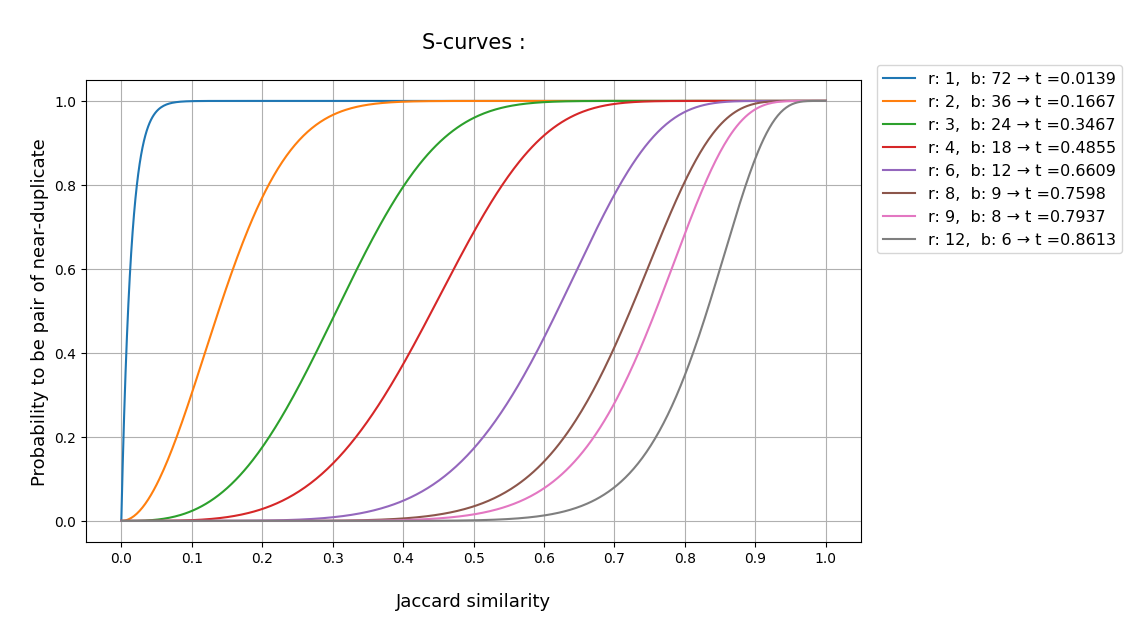

In [30]:
#YOUR CODE STARTS HERE#

j_sim, tresh =  0.93, 0.96

def formula(a,b):
    f = 1-((1-j_sim**a)**b); return f

n_list = [x for x in range(1,n_hashes+1) if n_hashes % x == 0]
x_r = list(zip(n_list, n_list[::-1]))
list_okconstr = [(x[0],x[1],formula(x[0],x[1])) for x in x_r if formula(x[0],x[1]) > tresh]

print("\nn_hashes:", n_hashes, " →", *[(x[0],x[1]) for x in list_okconstr],"\n")

plt.figure(figsize=(10,6))
for i in list_okconstr:
    f_array = [1 - (1 -(x)**i[0])**i[1] for x in np.linspace(0.0, 1, 500)]
    plt.plot(np.linspace(0.0, 1, 500), f_array)
        
plt.legend(["r: "+str(i[0])+",  b: "+str(i[1])+" → t ="+str(round((1/i[1])**(1/i[0]),4)) for i in list_okconstr], 
           fontsize=11.5, bbox_to_anchor=(1.01, 1.05))
plt.xticks(np.linspace(0.0, 1, 11))
plt.title("\nS-curves :\n", fontsize= 15)
plt.xlabel("\nJaccard similarity", fontsize=13)
plt.ylabel("\nProbability to be pair of near-duplicate", fontsize=13)

plt.grid(), plt.show();


#YOUR CODE ENDS HERE#
#THIS IS LINE 30#

### 2.1.6
Among all the configurations you plotted in the previous step, choose the one that gives the smallest amount of False-Positives and False-Negatives near-duplicates candidates, satisfying the provided constraints. You **must** take into account, that after the LSH procedure, the approximate Jaccard similarity between near-duplicate candidates is computed and used to reduce their number.

Provide an explanation for your choice in **at most 3 sentences**.

In [31]:
#YOUR CODE STARTS HERE#

erre, bi = 12, 6

#YOUR CODE ENDS HERE#
#THIS IS LINE 5#

------------YOUR TEXT STARTS HERE------------

**$\text{r}$** = $12$,
**$\text{b}$** = $6$

This combination reduces **false negatives**  → probability to be near-duplicate candidate = $0.9613$ for items with **Jaccard similarity** = $0.93$\
While **false positives** (already minimized by choosing the rightmost curve) will be discarded by the approximate **Jaccard similarity** between near-duplicate candidates

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 2.1.7
Load the file containing the MinWiseHashing sketches and perform Locality Sensivity Hashing, using the parameters you chose in last step, considering also the computation of approximate Jaccard to reduce the number of candidates. Save the Near-Duplicates candidates obtained to a file named `hw1_NearDuplicates_set_a_id_set_b_id_approximate_jaccard.tsv`.

Print the execution time.

In [33]:
#YOUR CODE STARTS HERE#

from DMT.minHash import LSH
l = LSH()

input_f_name = "hw1_set_id_MinWiseHashing_sketch.tsv" 
output_f_name = "hw1_NearDuplicates_set_a_id_set_b_id_approximate_jaccard.tsv"

st = time.time()
l.mine_couples_of_Near_Duplicates(input_file_name = input_f_name , output_file_name = output_f_name, 
                                  r = erre, b = bi, jaccard_threshold = j_sim)
et = time.time()

print('Execution time:', str(datetime.timedelta(seconds = et - st))[:10] , 'seconds')

#YOUR CODE ENDS HERE#
#THIS IS LINE 30#

Starting the loading of the MinWiseHashing sketches from the input file.


100%|█████████▉| 150000/150001.0 [00:21<00:00, 6903.93it/s]



Number of sets = 150000

Starting the mining of the CANDIDATES couples to be near duplicates.


100%|██████████| 6/6 [00:04<00:00,  1.33it/s]



Number of pairs of sets to be near-duplicate CANDIDATES = 20625


Number of REFINED pairs of sets to be near-duplicate CANDIDATES = 17604


FALSI POSITIVI =  3021

Execution time: 0:00:26.92 seconds


### 2.1.8
Load the file containing the number of near-duplicates candidates. Print the number of near-duplicates candidates you found.

In [34]:
#YOUR CODE STARTS HERE#

first_n = 5

output_file_name = "hw1_NearDuplicates_set_a_id_set_b_id_approximate_jaccard.tsv"

output_file = open(output_file_name, 'r', encoding="utf-8")
output_file_csv_reader = csv.reader(output_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
header = next(output_file_csv_reader)

this_list = [x for x in output_file_csv_reader if len(x)!=0 and float(x[2])> j_sim]

print("\nTotal number of near-duplicates candidates: ", len(this_list))
print("\n First {} Near-Duplicates candidates found :\n".format(first_n))

for i,record in enumerate(this_list[:first_n], 1):
    print(str(i)+')', "ID_1: {} \n   ID_2: {}  →  j_sim: {}".format(record[0], record[1], round(float(record[2]),3))); print()
    
output_file.close()

print("\nShowing similarity between Near Duplicates found :\n"); print()

for i in range(len(this_list[:4])):
  ind_list = [int(this_list[i][0]), int(this_list[i][1])]
  t = data[data['ID'].isin(ind_list)]; t["lyrics"] =  t["lyrics"].str[:15]+"..."
  print(tabulate(t, headers='keys', tablefmt = "heavy_outline", numalign='center', stralign="center"))
  print("")

#YOUR CODE ENDS HERE#
#THIS IS LINE 30#


Total number of near-duplicates candidates:  17604

 First 5 Near-Duplicates candidates found :

1) ID_1: 93123 
   ID_2: 93130  →  j_sim: 1.0

2) ID_1: 118894 
   ID_2: 118976  →  j_sim: 1.0

3) ID_1: 183011 
   ID_2: 183054  →  j_sim: 1.0

4) ID_1: 47496 
   ID_2: 180420  →  j_sim: 1.0

5) ID_1: 90741 
   ID_2: 90891  →  j_sim: 1.0


Showing similarity between Near Duplicates found :


        ID         song         year        artist        genre         lyrics
-----  -----  ---------------  ------  ----------------  -------  ------------------
65816  93123       fado         2007   charles-aznavour   jazz    du bist so komi...
65823  93130  sans-importance   2007   charles-aznavour   jazz    du bist so komi...

         ID       song       year           artist              genre            lyrics
-----  ------  -----------  ------  ----------------------  -------------  ------------------
84014  118894  rebelimao-n   2012   dancing-with-the-stars  not available  [** feat. phili.

## Part 2.2
You will be given a scenario and you will have to provide the best solution.

### 2.2.1

Let us consider the same scenario as in Part 2.1, with the only addition of not wanting more than 100 False Negatives. How would the choice of the LSH configuration change? Would you need any more information to satisfy the new constraint?

<br>

------------YOUR TEXT STARTS HERE------------

<br>

In this scenario perform a smaller number of hash functions should be the way.\
With only 6 minhash (r=3, b=2) we find Number of REFINED pairs of sets to be near-duplicate CANDIDATES = 19756\
However it would result in a significant increase of **false positives**.

The way this dataset is made, choosing a curve further to the left (lowering the treshold) does not change the number of false negatives, but it does affect false positives.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>


# Submission instructions

Follow the instructions precisely
1. Run the whole notebook up to this point
  * Click on this text cell and go to Runtime > Run before
  * It is essential that the notebook can be run from start to finish without us having to change anything.
2. Download the current notebook
  * File -> Download -> Download .ipynb
3. Upload the downloaded notebook in the current runtime
  * In the left sidebar menu, open the last tab (Files)
  * Click on the first button under the File title (Page with arrow pointing up)
  * In the new window, upload the notebook just downloaded



4. To turn the notebook into a pdf you need to install a Tex extension. Simply run the next cell of code:

In [ ]:
#REMOVE_CELL#
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-plain-generic is already the newest version (2019.202000218-1).
texlive-xetex is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


5. Now, run the next cell to set some cell tags in the notebook file.

In [ ]:
#REMOVE_CELL#
import nbformat as nbf
from glob import glob
notebooks = glob("/content/**/*.ipynb", recursive=True)

text_search_dict = ["YOUR TEXT STARTS HERE","#YOUR CODE STARTS HERE#"]

for ipath in notebooks:
    print(ipath)
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)

    for cell in ntbk.cells:
        cell_type = cell['cell_type'] == "code"
      
        cell_tags = cell.get('metadata', {}).get('tags', [])
        cell_tags = set(cell_tags)

        if cell_type == 0: #markdown
          if (cell['source'][0]!="#" and text_search_dict[cell_type] not in cell['source'] and "pagebreak" not in cell['source']) or "#REMOVE_CELL#" in cell['source']:
            cell_tags.add("remove_cell")

        else: #code
          #if text_search_dict[cell_type] not in cell['source'] or "#REMOVE_CELL#" in cell['source']:
          if "#REMOVE_CELL#" in cell['source']:
            cell_tags.add("remove_cell")
          elif "#REMOVE_OUTPUT#" in cell['source']:
            cell_tags.add("remove_output")
        
        if len(cell_tags) > 0:
            cell['metadata']['tags'] = list(cell_tags)

    nbf.write(ntbk, ipath)

/content/DMT2023_HW1.ipynb


6. Now, run the next cell to transform the notebook to PDF without the code cells.
  * The file will appear in the menu on the left (refresh if needed). The file should be named `DMT2023-HW1.pdf`
  * Rename this file **Surname1_Surname2_DMT2023HW1_report.pdf** (e.g. Becchetti_Siciliano_DMT2023HW1_report.pdf). Sort the surnames alphabetically.
  * Click on it and using the right button or the three dots at its side, click on download to transfer it to your local PC
  

In [ ]:
#REMOVE_CELL#
!jupyter nbconvert /content/DMT2023_HW1.ipynb --to pdf --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' -TagRemovePreprocessor.remove_all_outputs_tags='{"remove_output"}'

[NbConvertApp] Converting notebook /content/DMT2023_HW1.ipynb to pdf
[NbConvertApp] Support files will be in DMT2023_HW1_files/
[NbConvertApp] Making directory ./DMT2023_HW1_files
[NbConvertApp] Making directory ./DMT2023_HW1_files
[NbConvertApp] Writing 142919 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 283912 bytes to /content/DMT2023_HW1.pdf


7. Now, rename the downloaded notebook **Surname1_Surname2_DMT2023_HW1_notebook.ipynb** (e.g. Becchetti_Siciliano_DMT2023_HW1_notebook.ipynb). Sort the surnames alphabetically.

8. Now that you have both files, you need to upload them to Classroom. Only the student with the surname that comes first in alphabetical order **must** upload the files. Only the files uploaded by this student will be graded.